Домашнее задание 2: Построение простого классификатора изображений

Цель: Изучить применение методов машинного обучения для классификации изображений, сравнить эффективность классических алгоритмов и нейронных сетей.
Задание:
1. Подготовка данных:
    * Выберите набор данных:
        * MNIST для классификации рукописных цифр.
        * Или CIFAR-10 для классификации объектов в цветных изображениях.
    * Разделите данные на обучающую (80%) и тестовую (20%) выборки.

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Определим преобразования для данных
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразуем изображения в тензоры
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализуем данные
])

# Загрузим CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Создадим DataLoader для каждой выборки
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Обучающая выборка: {len(train_dataset)} изображений")
print(f"Тестовая выборка: {len(test_dataset)} изображений")

Обучающая выборка: 50000 изображений
Тестовая выборка: 10000 изображений


2. Классификация с использованием kNN или SVM:
    * Реализуйте классификатор k-ближайших соседей (kNN) или метод опорных векторов (SVM).
    * Обучите модель на обучающей выборке.
    * Предскажите классы на тестовой выборке.
    * Вычислите метрики качества: точность, полнота, F1-score.
    * Постройте матрицу ошибок (confusion matrix).

In [ ]:
# Преобразуем данные в numpy массивы
X_train = train_dataset.data  # (50000, 32, 32, 3)
y_train = np.array(train_dataset.targets)  # (50000,)
X_test = test_dataset.data  # (10000, 32, 32, 3)
y_test = np.array(test_dataset.targets)  # (10000,)

# Преобразуем изображения в одномерные векторы
X_train = X_train.reshape(X_train.shape[0], -1)  # (50000, 3072)
X_test = X_test.reshape(X_test.shape[0], -1)  # (10000, 3072)

# Нормализуем данные (значения пикселей от 0 до 255 -> от 0 до 1)
X_train = X_train / 255.0
X_test = X_test / 255.0

# Разделим данные на обучающую и тестовую выборки (80% / 20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
# Создадим и обучим модель kNN
knn = KNeighborsClassifier(n_neighbors=5)  # Используем 5 соседей
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [34]:
# Предскажем классы на тестовой выборке
y_pred = knn.predict(X_test)

In [36]:
# Вычислим метрики качества
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average='macro')
knn_recall = recall_score(y_test, y_pred, average='macro')
knn_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Точность (Accuracy): {knn_accuracy:.4f}")
print(f"Точность (Precision): {knn_precision:.4f}")
print(f"Полнота (Recall): {knn_recall:.4f}")
print(f"F1-score: {knn_f1:.4f}")

Точность (Accuracy): 0.3317
Точность (Precision): 0.4320
Полнота (Recall): 0.3317
F1-score: 0.3160


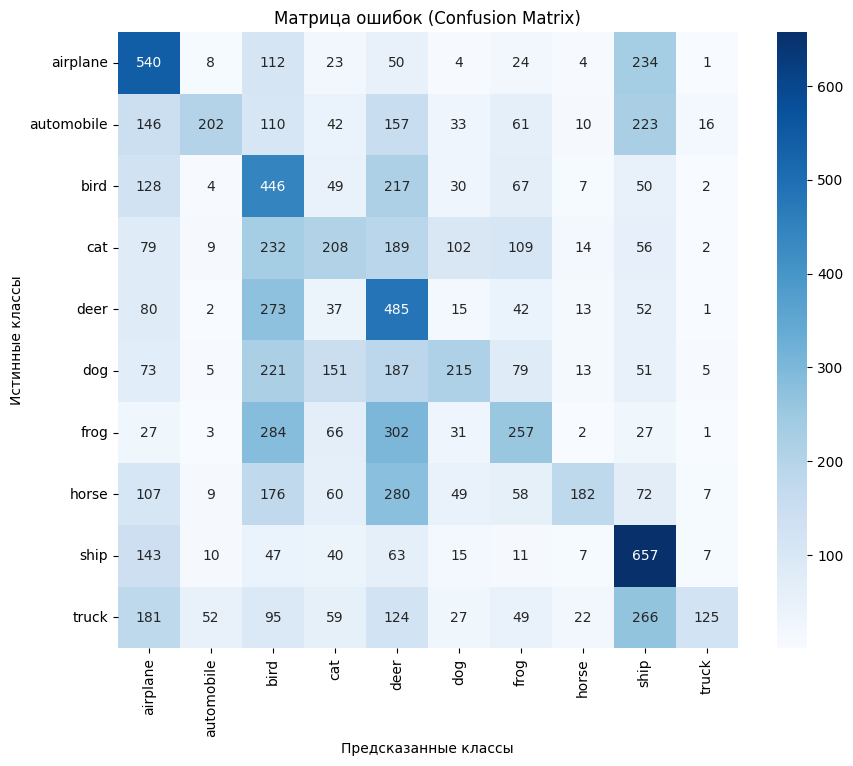

In [39]:
# Построим матрицу ошибок
knn_conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

3. Построение и обучение нейронной сети:
    * Создайте многослойный перцептрон (MLP) с использованием Keras или PyTorch.
    * Определите архитектуру сети (количество слоев, нейронов, функции активации).
    * Обучите модель на тех же данных.
    * Проанализируйте динамику обучения (графики потерь и точности).

In [21]:
# Проверка доступности GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Используемое устройство: {device}")

Используемое устройство: mps


In [22]:
# Разделим обучающую выборку на обучающую и валидационную (80% / 20%)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Создадим DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [23]:
# Определим архитектуру MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)  # Входной слой
        self.fc2 = nn.Linear(512, 256)          # Скрытый слой
        self.fc3 = nn.Linear(256, 10)           # Выходной слой
        self.relu = nn.ReLU()                   # Функция активации

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Преобразуем изображение в одномерный вектор
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
# Инициализация модели, функции потерь и оптимизатора
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()  # Функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор

In [25]:
# Обучение модели
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Обучение на обучающей выборке
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Эпоха [{epoch + 1}/{num_epochs}], "
          f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_accuracy:.4f}, "
          f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_accuracy:.4f}")

Эпоха [1/10], Потери на обучении: 1.6740, Точность на обучении: 0.4051, Потери на валидации: 1.5457, Точность на валидации: 0.4581
Эпоха [2/10], Потери на обучении: 1.4496, Точность на обучении: 0.4903, Потери на валидации: 1.4651, Точность на валидации: 0.4834
Эпоха [3/10], Потери на обучении: 1.3385, Точность на обучении: 0.5265, Потери на валидации: 1.4238, Точность на валидации: 0.5092
Эпоха [4/10], Потери на обучении: 1.2424, Точность на обучении: 0.5587, Потери на валидации: 1.4341, Точность на валидации: 0.5157
Эпоха [5/10], Потери на обучении: 1.1508, Точность на обучении: 0.5913, Потери на валидации: 1.4364, Точность на валидации: 0.5214
Эпоха [6/10], Потери на обучении: 1.0665, Точность на обучении: 0.6196, Потери на валидации: 1.4705, Точность на валидации: 0.5184
Эпоха [7/10], Потери на обучении: 0.9857, Точность на обучении: 0.6474, Потери на валидации: 1.4491, Точность на валидации: 0.5274
Эпоха [8/10], Потери на обучении: 0.9087, Точность на обучении: 0.6764, Потери на в

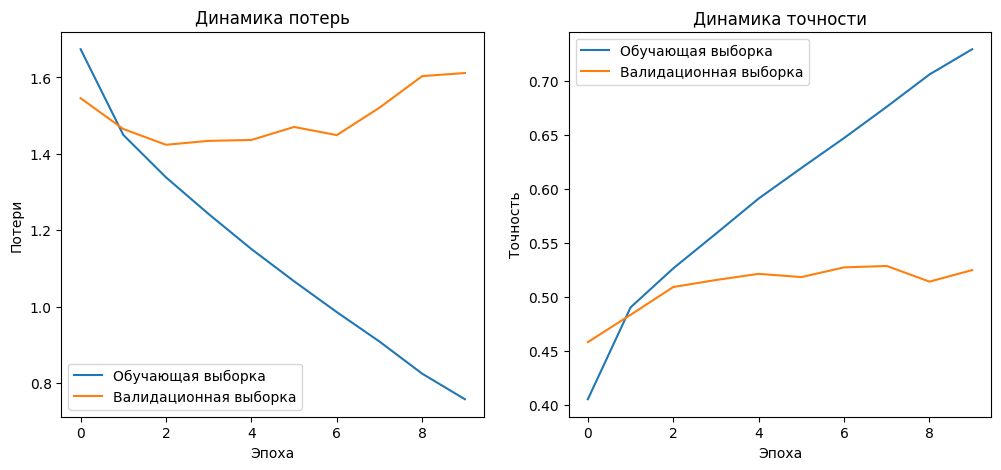

In [26]:
# Визуализация динамики обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Обучающая выборка')
plt.plot(val_losses, label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Динамика потерь')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Обучающая выборка')
plt.plot(val_accuracies, label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Динамика точности')
plt.legend()

plt.show()

In [40]:
# Переведем модель в режим оценки
model.eval()

# Предсказания на тестовой выборке
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [30]:
# Вычислим метрики качества
mlp_accuracy = accuracy_score(y_true, y_pred)
mlp_precision = precision_score(y_true, y_pred, average='macro')
mlp_recall = recall_score(y_true, y_pred, average='macro')
mlp_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Точность (Accuracy): {mlp_accuracy:.4f}")
print(f"Точность (Precision): {mlp_precision:.4f}")
print(f"Полнота (Recall): {mlp_recall:.4f}")
print(f"F1-score: {mlp_f1:.4f}")

Точность (Accuracy): 0.5227
Точность (Precision): 0.5195
Полнота (Recall): 0.5227
F1-score: 0.5189


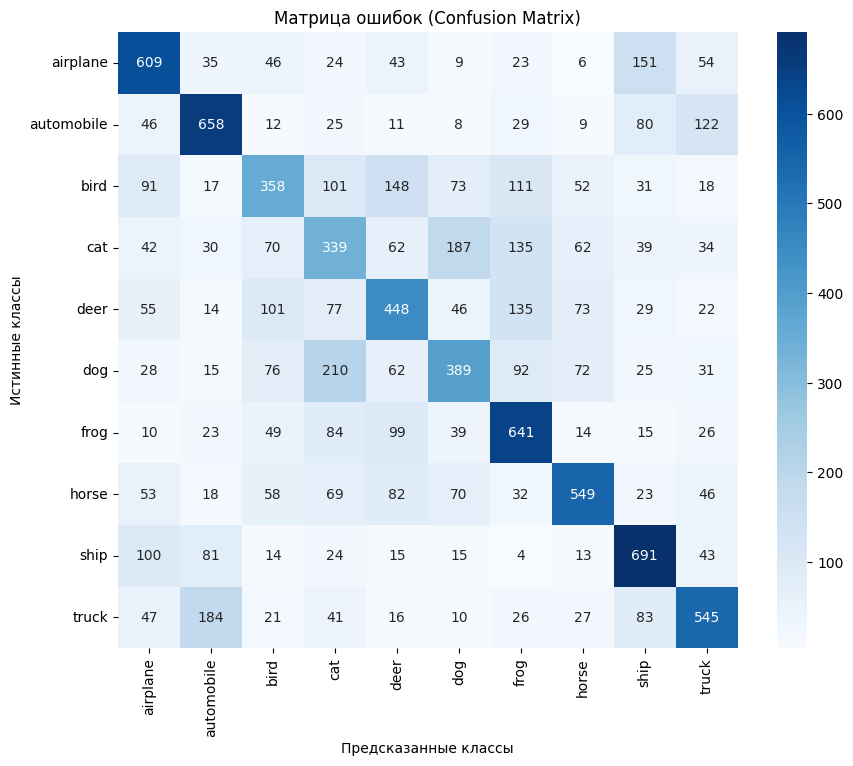

In [41]:
# Построим матрицу ошибок
mlp_conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.dataset.classes, 
            yticklabels=train_data.dataset.classes)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок (Confusion Matrix)')
plt.show()

4. Сравнительный анализ моделей:
    * Сравните результаты классического алгоритма (kNN/SVM) и нейронной сети.
    * Обсудите преимущества и недостатки каждого подхода.
    * Предложите способы улучшения моделей.

In [38]:
print(f'Точность (Accuracy) | MLP: {mlp_accuracy:.4f} | KNN: {knn_accuracy:.4f}')
print(f'Точность (Precision)| MLP: {mlp_precision:.4f} | KNN: {knn_precision:.4f}')
print(f'Полнота (Recall):   | MLP: {mlp_recall:.4f} | KNN: {knn_recall:.4f}')
print(f'F1-score:           | MLP: {mlp_f1:.4f} | KNN: {knn_f1:.4f}')

Точность (Accuracy) | MLP: 0.5227 | KNN: 0.3317
Точность (Precision)| MLP: 0.5195 | KNN: 0.4320
Полнота (Recall):   | MLP: 0.5227 | KNN: 0.3317
F1-score:           | MLP: 0.5189 | KNN: 0.3160


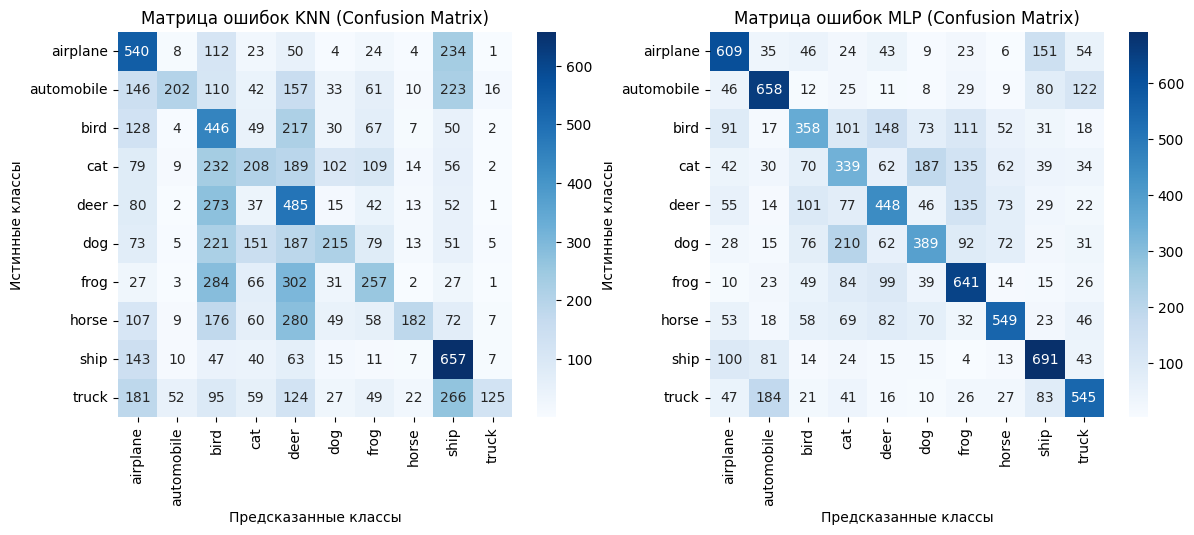

In [55]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
sns.heatmap(knn_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.dataset.classes, 
            yticklabels=train_data.dataset.classes)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок KNN (Confusion Matrix)')
plt.subplot(1,2,2)
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.dataset.classes, 
            yticklabels=train_data.dataset.classes)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок MLP (Confusion Matrix)')
plt.show()

Ожидаемо простой многослойный линейный перцептрон показал заметно лучший результат чем KNN. MLP также заметно быстрее работает, чем KNN.
Из интересного - MLP часто путает truck с automobile, что можно понять, когда как KNN путает truck с airplane)

Как улучшить? 
Изменить архитектуру, добавить свертки. 

In [73]:
class CifarCNN(nn.Module):
    def __init__(self):
        super(CifarCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
model = CifarCNN()

In [74]:
# Инициализация модели, функции потерь и оптимизатора
model = CifarCNN().to(device)
criterion = nn.CrossEntropyLoss()  # Функция потерь
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор

In [75]:
# Обучение модели
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Обучение на обучающей выборке
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валидация
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Эпоха [{epoch + 1}/{num_epochs}], "
          f"Потери на обучении: {train_loss:.4f}, Точность на обучении: {train_accuracy:.4f}, "
          f"Потери на валидации: {val_loss:.4f}, Точность на валидации: {val_accuracy:.4f}")

Эпоха [1/10], Потери на обучении: 1.5330, Точность на обучении: 0.4346, Потери на валидации: 1.1233, Точность на валидации: 0.6011
Эпоха [2/10], Потери на обучении: 1.1709, Точность на обучении: 0.5859, Потери на валидации: 0.9837, Точность на валидации: 0.6569
Эпоха [3/10], Потери на обучении: 1.0185, Точность на обучении: 0.6454, Потери на валидации: 0.8648, Точность на валидации: 0.6992
Эпоха [4/10], Потери на обучении: 0.9111, Точность на обучении: 0.6862, Потери на валидации: 0.8771, Точность на валидации: 0.6942
Эпоха [5/10], Потери на обучении: 0.8314, Точность на обучении: 0.7153, Потери на валидации: 0.7721, Точность на валидации: 0.7299
Эпоха [6/10], Потери на обучении: 0.7589, Точность на обучении: 0.7431, Потери на валидации: 0.8041, Точность на валидации: 0.7265
Эпоха [7/10], Потери на обучении: 0.7007, Точность на обучении: 0.7603, Потери на валидации: 0.7060, Точность на валидации: 0.7586
Эпоха [8/10], Потери на обучении: 0.6414, Точность на обучении: 0.7803, Потери на в

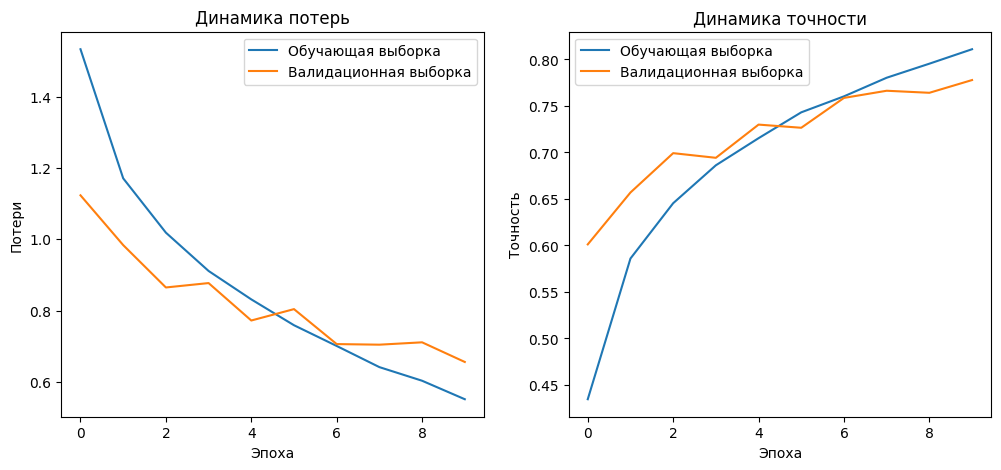

In [76]:
# Визуализация динамики обучения
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Обучающая выборка')
plt.plot(val_losses, label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Динамика потерь')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Обучающая выборка')
plt.plot(val_accuracies, label='Валидационная выборка')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Динамика точности')
plt.legend()

plt.show()

In [77]:
# Переведем модель в режим оценки
model.eval()

# Предсказания на тестовой выборке
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

In [78]:
# Вычислим метрики качества
mlp_accuracy = accuracy_score(y_true, y_pred)
mlp_precision = precision_score(y_true, y_pred, average='macro')
mlp_recall = recall_score(y_true, y_pred, average='macro')
mlp_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Точность (Accuracy): {mlp_accuracy:.4f}")
print(f"Точность (Precision): {mlp_precision:.4f}")
print(f"Полнота (Recall): {mlp_recall:.4f}")
print(f"F1-score: {mlp_f1:.4f}")

Точность (Accuracy): 0.7725
Точность (Precision): 0.7764
Полнота (Recall): 0.7725
F1-score: 0.7721


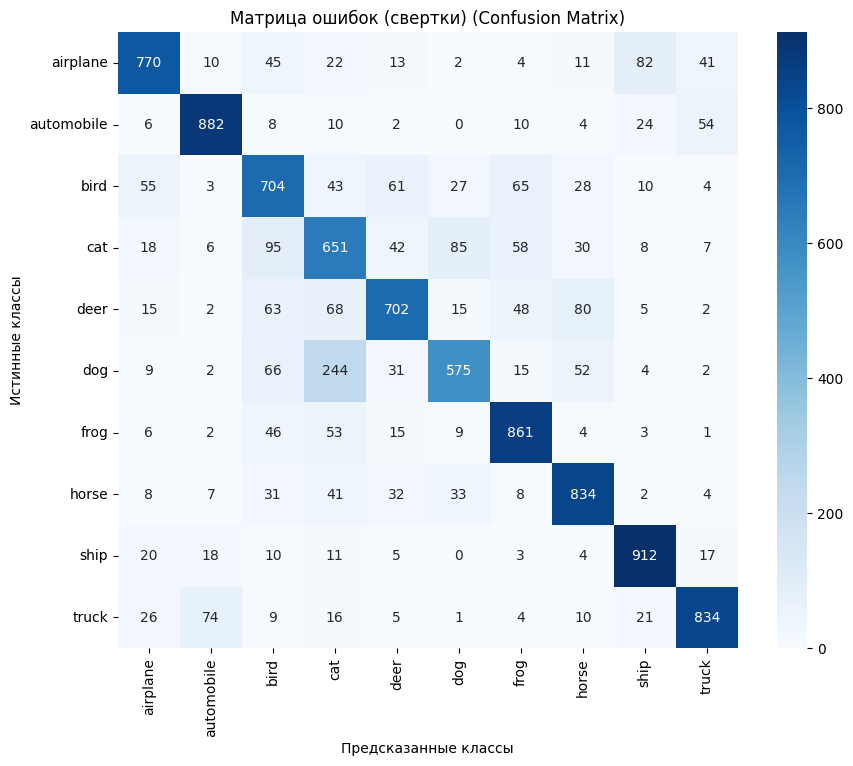

In [80]:
# Построим матрицу ошибок
conv_conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conv_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.dataset.classes, 
            yticklabels=train_data.dataset.classes)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок (свертки) (Confusion Matrix)')
plt.show()

Требования к оформлению:
* Отчет в формате PDF, содержащий:
    * Описание выбранных методов и настроек моделей.
    * Результаты обучения и тестирования (метрики, графики, матрицы ошибок).
    * Сравнительный анализ и выводы.
* Код программы с комментариями, загруженный на GitHub или приложенный к отчету.

Дополнительные указания:
* При выполнении заданий рекомендуется использовать Jupyter Notebook для удобства сочетания кода и пояснений.
* Поощряется самостоятельное исследование и применение дополнительных методов (например, нормализация данных, использование других метрик).
* В случае возникновения вопросов обращайтесь к преподавателю или используйте материалы лекций и семинаров.
